In [1]:
# Note: If you haven't installed the following dependencies, run:
!pip install xvfbwrapper
!pip install ffmpeg-python
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents
try:
    %tensorflow_version 2.x
except:
    pass

Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Requirement already up-to-date: tensorflow-probability in /Users/lingh/.pyenv/versions/3.7.0/envs/my-virtual-env

### Setup

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


#### Hyperparameters

In [3]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 250 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

#### Environment

In [4]:
env = suite_gym.load(env_name)

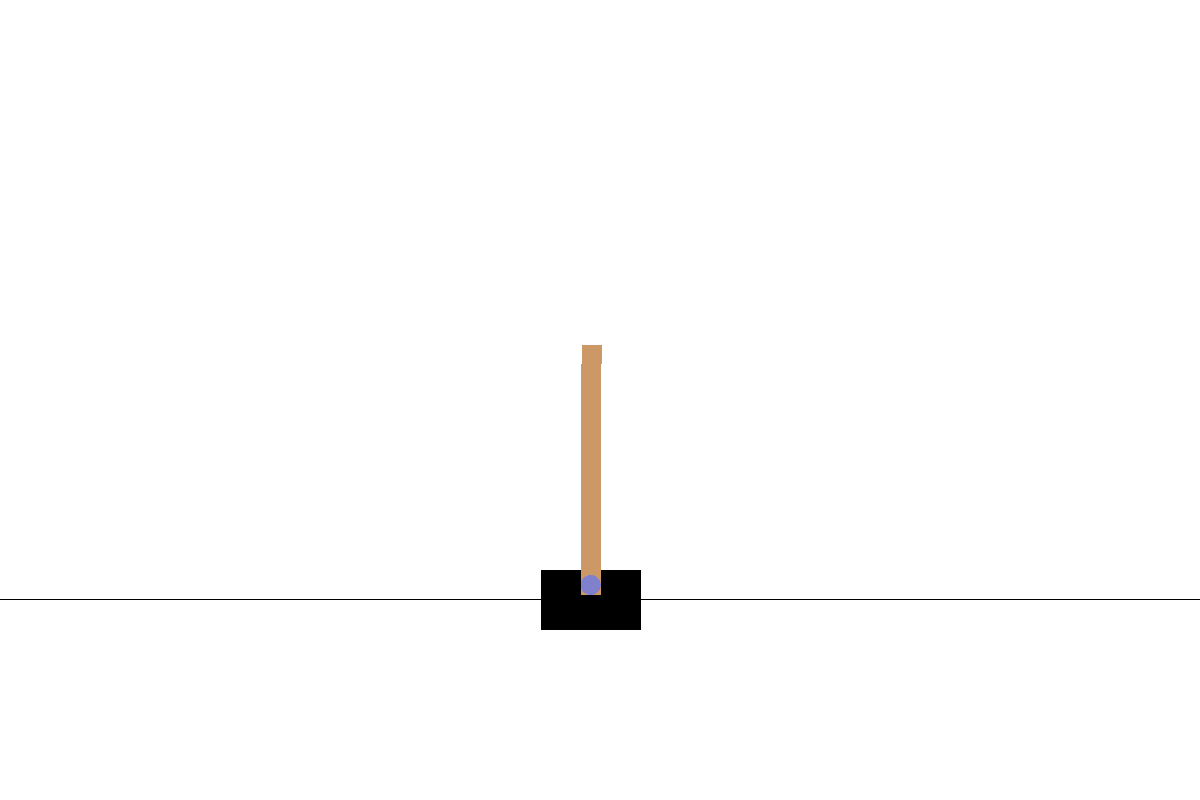

In [5]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

In [6]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [7]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = 1

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.03635828,  0.01859104,  0.01455543, -0.00464052], dtype=float32))
Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.03598646,  0.21350126,  0.01446262, -0.29269573], dtype=float32))


In [8]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

#### Agent

In [9]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [10]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

#### Policies

In [11]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

#### Metrics and Evaluation

In [12]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Please also see the metrics module for standard implementations of different

#### Replay Buffer

In [13]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

#### Data Collection

In [14]:
#@test {"skip": true}

def collect_episode(environment, policy, num_episodes):

    episode_counter = 0
    environment.reset()

    while episode_counter < num_episodes:
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        if traj.is_boundary():
            episode_counter += 1

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

#### Training the agent

In [15]:
#@test {"skip": true}
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few episodes using collect_policy and save to the replay buffer.
    collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

      # Use data from the buffer and update the agent's network.
    experience = replay_buffer.gather_all()
    train_loss = tf_agent.train(experience)
    replay_buffer.clear()

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.scan(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.scan(fn, elems))
step = 25: loss = 0.15058468282222748
step = 50: loss = -0.3121945858001709
step = 50: Average Return = 72.5
step = 75: loss = -0.2513261139392853
step = 100: loss = -1.7661876678466797
step = 100: Average Return = 136.8000030517578
step = 125: loss = -0.6415880918502808
step = 150: loss = -0.4751393795013428
step = 150: Average Return = 175.39999389648438
step = 175: loss = -0.3276538848876953
step = 200: loss = -2.7137019634246826
step = 200: Average Return = 196.89999389648438
step = 225: loss = -3.8385796546936035
step = 250: loss = -4.487182140350342
step = 250: Average Return = 200.0


#### Visualization

(-0.655000400543214, 250)

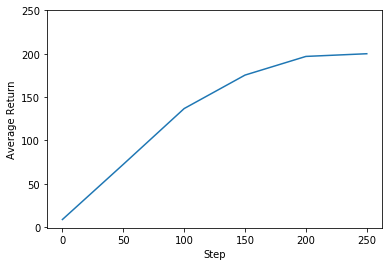

In [16]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

In [17]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

In [ ]:
num_episodes = 3
video_filename = "imageio.mp4"

with imageio.get_writer(video_filename, fps=6) as video:
    for _ in range(num_episodes):
        time_step = eval_env.reset()
        video.append_data(eval_py_env.render())
        while not time_step.is_last():
            action_step = tf_agent.policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render())
            
embed_mp4(video_filename)